In [1]:
from collections import defaultdict
import pandas as pd
from surprise import Reader, Dataset
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt

In [3]:
class RefinedMyAlgo():
    def __init__(self, rating_data='', data_frame='', movie_data=''):
        if rating_data:
            reader = Reader(line_format='user item rating timestamp', sep=',')
            self.ratings = Dataset.load_from_file(rating_data, reader)
#             self.trainset, self.testset = train_test_split(self.ratings, test_size=0.25)
            self.trainset = self.ratings.build_full_trainset()
            self.sim_options = {'name': 'cosine','user_based': False}
        elif not data_frame.empty:
            reader = Reader(rating_scale=(0, 5))
            self.ratings = Dataset.load_from_df(data_frame[['userId', 'movieId', 'rating']], reader)
            self.trainset = self.ratings.build_full_trainset()
            self.sim_options = {'name': 'cosine','user_based': False}
            
        if movie_data:
            self.movies = pd.read_csv(movie_data, low_memory=False)

        
    def set_k(self, k_value):
        algo = KNNWithMeans(k=k_value, sim_options=self.sim_options)
        self.algo = algo
        self.algo.fit(self.trainset)
        
        
    def find_best_k(self, k_value=''):
        if k_value:
            print('K = {}'.format(k_value))
            algo = KNNWithMeans(k=k_value, sim_options=self.sim_options)
            return cross_validate(algo, self.ratings, measures=['RMSE', 'MAE'], cv=10, verbose=True)
        else:
            aux = []
            for k_value in [3, 5, 7, 10, 15, 20, 30, 40]:
                print('K = {}'.format(k_value))
                algo = KNNWithMeans(k=k_value, sim_options=self.sim_options)
                my_dict = cross_validate(algo, self.ratings, measures=['RMSE', 'MAE'], cv=10, verbose=False)
                my_dict['k_value'] = k_value
                aux.append(my_dict)
            return aux
        
        
    def get_top_n(self, predictions, n=10):
        '''Return the top-N recommendation for each user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        '''

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))

        # Then sort the predictions for each user and retrieve the k highest ones.
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]

        return top_n
    
    
    def set_testset(self, users):
        if users:
            user_ratings = self.trainset.ur
            movies_ids = list(self.movies['movieId'])
            global_mean=self.trainset.global_mean
            my_testset = []
            
            for user in users:
                iuid = self.trainset.to_inner_uid(str(user))
                for movie in movies_ids:
                    is_in = False
                    for rating in user_ratings[iuid]:
#                         print( 'MOVIE: {}, RATING: {}'.format(movie,bla.trainset.to_raw_iid(rating[0])) )
                        if int(movie) == int(self.trainset.to_raw_iid(int(rating[0]))):
                            is_in = True
                            break
                    if not is_in:
                        my_tuple = (str(user),str(movie),global_mean)
                        my_testset.append(my_tuple)
                        
            self.testset = my_testset
        else:
            testset = self.trainset.build_anti_testset()
            self.testset = testset
        return self.testset


    def predict_ratings(self,users=''):
        # # Predict ratings for all pairs (u, i) that are NOT in the training set.
#         testset = self.trainset.build_anti_testset()
#         self.testset = testset
        testset = self.set_testset(users)
        predictions = self.algo.test(testset)
        self.predictions = predictions
        
        
    def recs_for_user(self, uid):
        user_filtered = list(filter(lambda x: x.uid == str(uid), self.predictions))
        print(len(user_filtered))
        top_n = self.get_top_n(predictions=user_filtered, n=10)
        
        return top_n

In [4]:
refinedMyAlgo = RefinedMyAlgo(rating_data='ml-latest-small/ratings.csv', movie_data='ml-latest-small/movies.csv')
refinedMyAlgo.set_k(k_value=10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [5]:
my_dict = refinedMyAlgo.find_best_k(k_value=10)

K = 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9255  0.9099  0.9366  0.9172  0.92

In [8]:
my_dict
# my_dict['test_rmse'].mean()

{'test_rmse': array([0.92545303, 0.90985071, 0.93658588, 0.91720509, 0.92600537,
        0.9465585 , 0.92015479, 0.92702844, 0.92852067, 0.92622924]),
 'test_mae': array([0.70724054, 0.69452052, 0.7163483 , 0.70336004, 0.7068464 ,
        0.72220273, 0.70276858, 0.70877941, 0.7107792 , 0.7087099 ]),
 'fit_time': (88.60136437416077,
  90.01052498817444,
  84.53042411804199,
  87.12358713150024,
  69.12656259536743,
  68.96707224845886,
  69.0747435092926,
  78.69056701660156,
  66.88483810424805,
  67.73706650733948),
 'test_time': (10.276524305343628,
  11.235456705093384,
  13.332575559616089,
  9.988584995269775,
  9.972211837768555,
  10.552303075790405,
  10.11411738395691,
  9.43347692489624,
  9.520493030548096,
  9.490260362625122)}

In [4]:
refinedMyAlgo.predict_ratings(users=[2,5])
len(refinedMyAlgo.predictions)

19411

In [ ]:
########## Matplotlib LINKs

# https://python-graph-gallery.com/122-multiple-lines-chart/
    
# https://stackoverflow.com/questions/36184953/specifying-values-for-my-x-axis-using-the-matplotlib-pyplot
    
# https://matplotlib.org/users/pyplot_tutorial.html

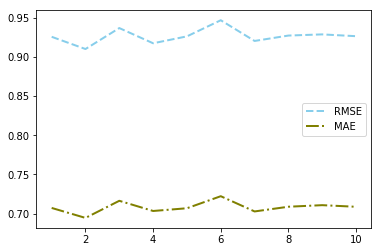

In [14]:
df = pd.DataFrame({'x': range(1,11), 'rmse': my_dict['test_rmse'], 'mae': my_dict['test_mae'] })

plt.plot( 'x', 'rmse', data=df, linestyle='--', color='skyblue', linewidth=2, label='RMSE')
plt.plot( 'x', 'mae', data=df, linestyle='-.', color='olive', linewidth=2, label='MAE')
plt.legend()